In [1]:
# hydrological packages
import hydroeval as he
from hydrotools.nwm_client import utils # I had to pip install this
import FigureGenerator

# basic packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# system packages
from progressbar import ProgressBar
from datetime import datetime, date
import pickle
import warnings
warnings.filterwarnings("ignore")
import platform
import time

# data analysi packages
from scipy import optimize
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# deep learning packages
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [3]:
if platform.system() == 'Windows':
    onedrive_path = 'E:/OneDrive/OneDrive - The University of Alabama/10.material/01.data/usgs_data/'
    box_path = 'C:/Users/snaserneisary/Box/NWM-ML/'

elif platform.system() == 'Darwin':
    onedrive_path = '/Users/savalan/Library/CloudStorage/OneDrive-TheUniversityofAlabama/02.projects/03.ciroh/04.data/'
    box_path = '/Users/savalan/Library/CloudStorage/Box-Box/NWM-ML/Data/NWM/ut/'
    
elif platform.system() == 'Linux':
    path_01 = '/home/ec2-user/SageMaker/01.projects/01.ciroh_p8/NWM-ML/savalan/'

In [4]:


def Model_Evaluation_Plots(DF, predictions):

# Subplots.
    fig, ax = plt.subplots(1,1, figsize=(8, 7))
    fig.patch.set_facecolor('white')

    #set min/max for y-axis of the predictions/observations
    ymin = min(DF['flow_cfs'])*1.1
    ymax = max(DF['flow_cfs'])*1.1

    #add color options
    colors = ['blue', 'orange', 'red','green']


    # Add predictions to plot
    for pred in np.arange(0, len(predictions),1):
        ax.scatter(DF['flow_cfs'], DF[predictions[pred]],
                   c=colors[pred], alpha=0.35, label=predictions[pred])

     # Add some parameters.
    ax.set_title('Streamflow Predictions', fontsize=16)
    ax.set_xlabel('Observations (cfs)', fontsize=14)
    ax.set_ylabel('Predictions (cfs)', fontsize=14,)
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(ymin, ymax)
    ax.legend(fontsize=14, loc='upper right')

    #Add a 1:1 prediction:observation plot
    ax.plot((0,ymax),(0,ymax), linestyle = '--', color  = 'red')

    plt.show()


#Define some key model performance metics: RMSE, PBias, MAE, MAPE
def RMSE(DF, predictions):
    R = []
    for pred in np.arange(0, len(predictions),1):
        rmse = mean_squared_error(DF['flow_cfs'], DF[predictions[pred]], squared=False)
        R.append(rmse)
        #print('RMSE for ', predictions[pred], ' is ', rmse, ' cfs')
    return R

def MAPE(DF, predictions):
    P =[]
    for pred in np.arange(0, len(predictions),1):
        mape = round(mean_absolute_percentage_error(DF['flow_cfs'], DF[predictions[pred]])*100, 2)
        P.append(mape)
        #print('Mean Absolute Percentage Error for ', predictions[pred], ' is ', mape, '%')
    return P

def PBias(DF, predictions):
    PB = []
    for pred in np.arange(0, len(predictions),1):
        pbias = he.evaluator(he.pbias,  DF[predictions[pred]], DF['flow_cfs'])
        pbias = round(pbias[0],2)
        PB.append(pbias)
        #print('Percentage Bias for ', predictions[pred], ' is ', pbias, '%')
    return PB    
  
def KGE(DF, predictions):
    KG = []
    for pred in np.arange(0, len(predictions),1):
        kge, r, alpha, beta = he.evaluator(he.kge,  DF[predictions[pred]], DF['flow_cfs'])
        kge = round(kge[0],2)
        KG.append(kge)
        #print('Kling-Glutz Efficiency for ', predictions[pred], ' is ', kge)
    return KG

In [5]:
raw_training_data = pd.read_csv(path_01 + '03.output/raw_training_data.csv')
raw_training_data.pop('Unnamed: 0')
raw_training_data['station_id'] = raw_training_data['station_id'].astype('str')
raw_training_data

,station_id,Lat,Long,Drainage_area_mi2,Mean_Basin_Elev_ft,Perc_Forest,Perc_Develop,Perc_Imperv,Perc_Herbace,Perc_Slop_30,...,datetime,flow_cfs,s1,s2,temperature_F,precipitation_in,storage,swe,NWM_flow,DOY
0,10011500,40.965225,-110.853508,174.00,9720.0,67.70,1.2,0.120,2.94,27.2,...,2012-03-13,45.356945,0.515038,0.857167,35.096,0.00000,0.0,7.70,60.0,73
1,10011500,40.965225,-110.853508,174.00,9720.0,67.70,1.2,0.120,2.94,27.2,...,2012-03-14,49.750000,0.515038,0.857167,35.258,0.00000,0.0,7.45,62.0,74
2,10011500,40.965225,-110.853508,174.00,9720.0,67.70,1.2,0.120,2.94,27.2,...,2012-03-15,52.483334,0.515038,0.857167,36.860,0.00000,0.0,7.35,65.0,75
3,10011500,40.965225,-110.853508,174.00,9720.0,67.70,1.2,0.120,2.94,27.2,...,2012-03-16,60.296875,0.515038,0.857167,38.120,0.00000,0.0,7.25,63.0,76
4,10011500,40.965225,-110.853508,174.00,9720.0,67.70,1.2,0.120,2.94,27.2,...,2012-03-17,68.876045,0.515038,0.857167,38.102,0.04698,0.0,6.85,65.0,77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60039,10172952,41.858530,-113.327219,8.57,8190.0,6.01,0.0,0.021,40.20,57.5,...,2020-02-25,1.530000,0.000000,1.000000,27.644,0.00000,0.0,0.00,1.0,56
60040,10172952,41.858530,-113.327219,8.57,8190.0,6.01,0.0,0.021,40.20,57.5,...,2020-02-26,1.530000,0.000000,1.000000,29.876,0.00000,0.0,0.00,1.0,57
60041,10172952,41.858530,-113.327219,8.57,8190.0,6.01,0.0,0.021,40.20,57.5,...,2020-02-27,1.545208,0.000000,1.000000,35.438,0.00000,0.0,0.00,1.0,58
60042,10172952,41.858530,-113.327219,8.57,8190.0,6.01,0.0,0.021,40.20,57.5,...,2020-02-28,1.717708,0.000000,1.000000,38.498,0.00000,0.0,0.00,1.0,59


In [6]:
Training_DF = raw_training_data.copy()

### Editing the features based on the feature importance should be in the next cell!!!!!!!!!!!!!!!

In [7]:
# Editing the features based on the feature importance should be done here!!!!!!!!!!!!!!!

Training_DF.drop(['precipitation_in', 'temperature_F', 'Mean_Ann_Precip_in', 'Perc_Herbace', 'Perc_Forest',
                        'Mean_Basin_Elev_ft'], axis=1, inplace=True)



### Remove headwater stations!!!!!!!

In [8]:
headwater_stations = ['10011500', '10109000', '10113500', '10128500', '10131000', '10146400', '10150500', '10154200',
'10172700', '10172800', '10172952']
Training_DF = Training_DF[~Training_DF['station_id'].isin(headwater_stations)]

In [9]:
Training_DF.datetime = pd.to_datetime(Training_DF.datetime)

Training_DF


,station_id,Lat,Long,Drainage_area_mi2,Perc_Develop,Perc_Imperv,Perc_Slop_30,datetime,flow_cfs,s1,s2,storage,swe,NWM_flow,DOY
789,10126000,41.576321,-112.100782,7040.0,4.28,0.55,1.94,2012-03-01,1488.437500,0.515038,0.857167,85.588235,12.778571,1542.0,61
790,10126000,41.576321,-112.100782,7040.0,4.28,0.55,1.94,2012-03-02,1282.187500,0.515038,0.857167,86.712418,13.085714,1542.0,62
791,10126000,41.576321,-112.100782,7040.0,4.28,0.55,1.94,2012-03-03,1269.479100,0.515038,0.857167,87.359477,13.178571,1542.0,63
792,10126000,41.576321,-112.100782,7040.0,4.28,0.55,1.94,2012-03-04,1551.562500,0.515038,0.857167,88.163399,13.221429,1541.0,64
793,10126000,41.576321,-112.100782,7040.0,4.28,0.55,1.94,2012-03-05,1490.520900,0.515038,0.857167,89.026144,13.221429,1541.0,65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59374,10171000,40.733557,-111.923270,3430.0,14.70,4.37,4.94,2020-02-25,124.114586,0.000000,1.000000,0.000000,0.000000,3331.0,56
59375,10171000,40.733557,-111.923270,3430.0,14.70,4.37,4.94,2020-02-26,120.604164,0.000000,1.000000,0.000000,0.000000,3331.0,57
59376,10171000,40.733557,-111.923270,3430.0,14.70,4.37,4.94,2020-02-27,120.354164,0.000000,1.000000,0.000000,0.000000,3331.0,58
59377,10171000,40.733557,-111.923270,3430.0,14.70,4.37,4.94,2020-02-28,97.020836,0.000000,1.000000,0.000000,0.000000,3330.0,59


In [10]:
x_train_temp = Training_DF[Training_DF.datetime.dt.year != 2020]
x_train_temp.pop('station_id')
x_train_temp.pop('datetime')
y_train_temp = x_train_temp['flow_cfs']
x_train_temp.pop('flow_cfs')
x_train_temp

,Lat,Long,Drainage_area_mi2,Perc_Develop,Perc_Imperv,Perc_Slop_30,s1,s2,storage,swe,NWM_flow,DOY
789,41.576321,-112.100782,7040.0,4.28,0.55,1.94,0.515038,0.857167,85.588235,12.778571,1542.0,61
790,41.576321,-112.100782,7040.0,4.28,0.55,1.94,0.515038,0.857167,86.712418,13.085714,1542.0,62
791,41.576321,-112.100782,7040.0,4.28,0.55,1.94,0.515038,0.857167,87.359477,13.178571,1542.0,63
792,41.576321,-112.100782,7040.0,4.28,0.55,1.94,0.515038,0.857167,88.163399,13.221429,1541.0,64
793,41.576321,-112.100782,7040.0,4.28,0.55,1.94,0.515038,0.857167,89.026144,13.221429,1541.0,65
...,...,...,...,...,...,...,...,...,...,...,...,...
59345,40.733557,-111.923270,3430.0,14.70,4.37,4.94,0.000000,1.000000,0.000000,0.000000,3413.0,55
59346,40.733557,-111.923270,3430.0,14.70,4.37,4.94,0.000000,1.000000,0.000000,0.000000,3415.0,56
59347,40.733557,-111.923270,3430.0,14.70,4.37,4.94,0.000000,1.000000,0.000000,0.000000,3415.0,57
59348,40.733557,-111.923270,3430.0,14.70,4.37,4.94,0.000000,1.000000,0.000000,0.000000,3413.0,58


In [11]:
y_train = y_train_temp.to_numpy()

x_train = x_train_temp.to_numpy()

scaler = MinMaxScaler()


x_train_scaled = scaler.fit_transform(x_train)

y_scaled_train = scaler.fit_transform(y_train.reshape(-1, 1))


In [12]:
y_scaled_train.shape

(24069, 1)

In [13]:
x_test_temp = Training_DF[Training_DF.datetime.dt.year == 2020]
x_test_temp

,station_id,Lat,Long,Drainage_area_mi2,Perc_Develop,Perc_Imperv,Perc_Slop_30,datetime,flow_cfs,s1,s2,storage,swe,NWM_flow,DOY
1029,10126000,41.576321,-112.100782,7040.0,4.28,0.55,1.94,2020-03-01,1642.395900,0.515038,0.857167,64.241830,14.914286,1012.0,61
1030,10126000,41.576321,-112.100782,7040.0,4.28,0.55,1.94,2020-03-02,1724.270900,0.515038,0.857167,64.215686,15.142857,1011.0,62
1031,10126000,41.576321,-112.100782,7040.0,4.28,0.55,1.94,2020-03-03,1751.250000,0.515038,0.857167,64.189542,15.135714,1010.0,63
1032,10126000,41.576321,-112.100782,7040.0,4.28,0.55,1.94,2020-03-04,1675.416600,0.515038,0.857167,64.189542,15.135714,1009.0,64
1033,10126000,41.576321,-112.100782,7040.0,4.28,0.55,1.94,2020-03-05,1697.812500,0.515038,0.857167,64.241830,15.085714,1008.0,65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59374,10171000,40.733557,-111.923270,3430.0,14.70,4.37,4.94,2020-02-25,124.114586,0.000000,1.000000,0.000000,0.000000,3331.0,56
59375,10171000,40.733557,-111.923270,3430.0,14.70,4.37,4.94,2020-02-26,120.604164,0.000000,1.000000,0.000000,0.000000,3331.0,57
59376,10171000,40.733557,-111.923270,3430.0,14.70,4.37,4.94,2020-02-27,120.354164,0.000000,1.000000,0.000000,0.000000,3331.0,58
59377,10171000,40.733557,-111.923270,3430.0,14.70,4.37,4.94,2020-02-28,97.020836,0.000000,1.000000,0.000000,0.000000,3330.0,59


In [14]:
x_test_temp_1 = x_test_temp.copy()
station_index_list = x_test_temp_1['station_id']
x_test_temp_1.pop('station_id')
x_test_temp_1.pop('datetime')
y_test_temp_1 = x_test_temp_1['flow_cfs']
x_test_temp_1.pop('flow_cfs')
x_test_1_np = x_test_temp_1.reset_index(drop=True).to_numpy()
y_test_1_np = y_test_temp_1.reset_index(drop=True).to_numpy()
x_test_1_scaled = scaler.fit_transform(x_test_1_np)
y_scaled_test_1 = scaler.fit_transform(y_test_1_np.reshape(-1, 1))

In [15]:
# %% CNN

n_targets = 1

tries = 10


cri_temp_nse = np.zeros([3, n_targets, tries])

cri_temp_rmse = np.zeros([3, n_targets, tries])

cri_temp_r2 = np.zeros([3, n_targets, tries])

cri_temp_kge = np.zeros([3, n_targets, tries])

cri_temp_lognse = np.zeros([3, n_targets, tries])


#remove first column
#Training_DF.pop('Unnamed: 0')

#Split the data into features and target
#y = Training_DF['flow_cfs'].to_numpy()

#remove target from features
#Training_DF.pop('flow_cfs')

#x = Training_DF.to_numpy()

'''The DataFrame looks good, now lets scale the data.
XGBoost does not require this but others do and it is a good housekeeping step.
'''



# split data into train and test sets
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=1)

#x_scaled = scaler.fit_transform(x)

#y_scaled = scaler.fit_transform(y.reshape(-1, 1))

#x_train_scaled, x_test_scaled, y_train_scaled, y_test_scaled = train_test_split(x_scaled, y_scaled, test_size=0.33, random_state=1)

print('finish')


finish


In [16]:
# Reshape Input for LSTM Model
x_train_scaled_test = torch.Tensor(x_train_scaled).unsqueeze(2)
y_train_scaled_test = torch.Tensor(y_scaled_train).unsqueeze(2)




In [17]:
x_train_scaled_test.shape

torch.Size([24069, 12, 1])

In [18]:
y_train_scaled_test.shape

torch.Size([24069, 1, 1])

In [19]:
x_train_scaled_test = x_train_scaled_test.to(device)
y_train_scaled_test = y_train_scaled_test.to(device)

In [20]:
device

device(type='cuda')

In [23]:

import datetime

# Assuming you have your data loaded into NumPy arrays as x_train_scaled, y_train_scaled, x_test_scaled, y_test_scaled, x_scaled, y_scaled



# Hyperparameters
epochs = 20
batch_size = 100
learning_rate = 0.001
decay = 1e-2
validation_split = 0.2
neurons = 150

# Create PyTorch datasets and dataloaders
train_dataset = TensorDataset(x_train_scaled_test, y_train_scaled_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size)

# Build the model
model = nn.Sequential(
    nn.Conv1d(12, out_channels=64, kernel_size=1),
    nn.ReLU(),
    nn.MaxPool1d(kernel_size=1),
    nn.Flatten(),
    nn.Linear(64, 50),
    nn.ReLU(),
    nn.Linear(50, 1)
).to(device)


# Define loss and optimizer
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=decay) #

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        output= model(batch_x)
        
        loss = criterion(output, batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_loader)}")

print('finish, saving model')


#save model
torch.save(model.state_dict(), f"./cnn_models/cnn_model.pkl")

Epoch 1/20, Loss: 0.03373484027183603
Epoch 2/20, Loss: 0.024250722975958972
Epoch 3/20, Loss: 0.023791327272615244
Epoch 4/20, Loss: 0.023282715470841178
Epoch 5/20, Loss: 0.023155276376185977
Epoch 6/20, Loss: 0.023025892491001225
Epoch 7/20, Loss: 0.02303334765478725
Epoch 8/20, Loss: 0.023090302649642923
Epoch 9/20, Loss: 0.023166321391791405
Epoch 10/20, Loss: 0.023212008101428972
Epoch 11/20, Loss: 0.023213292447670415
Epoch 12/20, Loss: 0.023232636877134658
Epoch 13/20, Loss: 0.023237708606757224
Epoch 14/20, Loss: 0.02323378525921665
Epoch 15/20, Loss: 0.023219147450614264
Epoch 16/20, Loss: 0.023226987754928985
Epoch 17/20, Loss: 0.023220122172313652
Epoch 18/20, Loss: 0.023206469199776696
Epoch 19/20, Loss: 0.02320439689739557
Epoch 20/20, Loss: 0.02319664100167647
finish, saving model


In [33]:
# %%    # Evaluation - note, changed model to models to make sure saving/loading worked
#load model
models = nn.Sequential(
    nn.Conv1d(12, out_channels=64, kernel_size=1),
    nn.ReLU(),
    nn.MaxPool1d(kernel_size=1),
    nn.Flatten(),
    nn.Linear(64, 50),
    nn.ReLU(),
    nn.Linear(50, 1)
).to(device)

models.load_state_dict(torch.load(f"./cnn_models/cnn_model.pkl"))

#put the model scores into a dataframe for comparison
#put the model scores into a dataframe for comparison
mod = 'CNN'
cols = ['USGSid', 'NHDPlusid', 'NWM_rmse', f"{mod}_rmse", 'NWM_pbias', f"{mod}_pbias", 'NWM_kge', f"{mod}__kge", 'NWM_mape',  f"{mod}_mape"]EvalDF = pd.DataFrame(columns = cols )

SitesDict = {}


for station_number in station_index_list.drop_duplicates():
    #print(station_number)
    index = station_index_list == station_number
    device = torch.device('cuda')
    x_train_scaled_test = x_train_scaled_test.to(device)
    models = models.to(device)


    X_test = x_test_temp_1[index]

    X_test_scaled = torch.Tensor(x_test_1_scaled[index]).unsqueeze(2).to(device)
    y_test = y_test_temp_1[index]

    models.eval()
    with torch.no_grad():
        yhat_test= models(X_test_scaled)


    # Invert scaling for actual
    device = torch.device('cpu')

    yhat_test = yhat_test.to(device)


    inv_yhat_test = scaler.inverse_transform(yhat_test.numpy())
    
    inv_yhat_test[inv_yhat_test<0] = 0
    #print('finish')
    # %%

    #nwm_lstm = np.concatenate((inv_yhat_train, inv_yhat_test), axis=0)

    nwm_test = pd.DataFrame(inv_yhat_test, columns=['CNN_flow'])

    Dfs = [nwm_test.reset_index(drop=True), x_test_temp_1[index].reset_index(drop=True), y_test.reset_index(drop=True)]
    
    #save predictions, need to convert to NHDPlus reach - Need to add Datetime column and relable flow predictions
    #make daterange
    dates = pd.date_range(pd.to_datetime("2020-01-01"), periods=len(nwm_test)).strftime("%Y-%m-%d").tolist()
    nwm_test['Datetime'] = dates
    #put columns in correct order
    cols = ['Datetime', 'CNN_flow']
    nwm_test = nwm_test[cols]
    
    #get reach id for model eval
    nhdreach = utils.crosswalk(usgs_site_codes=station_number)
    nhdreach = nhdreach['nwm_feature_id'].iloc[0]
    
    #save predictions
    mod = 'CNN'
    save_path = f"./Predictions/Hindcast/{mod}/{mod}_{nhdreach}.csv"
    nwm_test.to_csv(save_path)
    
      # merge
    Eval_DF_mine = pd.concat(Dfs, axis=1)
    prediction_columns = [ 'NWM_flow', 'CNN_flow']

    #plot the predictions
   # Model_Evaluation_Plots(Eval_DF_mine, prediction_columns)

    #Get RMSE from the model
    rmse = RMSE(Eval_DF_mine, prediction_columns)

    #Get Mean Absolute Percentage Error from the model
    mape = MAPE(Eval_DF_mine, prediction_columns)

    #Get Percent Bias from the model
    pbias = PBias(Eval_DF_mine, prediction_columns)

    #Get Kling-Gutz Efficiency from the model
    kge = KGE(Eval_DF_mine, prediction_columns)
    
    #save model performance
    sitestats = [station_number, nhdreach, rmse[0], rmse[1],  pbias[0], pbias[1], kge[0], kge[1], mape[0],  mape[1]]
    EvalDF.loc[len(EvalDF)] = sitestats
    
    #put prediction DF into dictionary
    Eval_DF_mine.sort_values(by=['DOY'], inplace=True)
    Eval_DF_mine['Datetime'] = pd.to_datetime(dates)
    Eval_DF_mine.set_index('Datetime', inplace = True)
    SitesDict[nhdreach] = Eval_DF_mine
    
    
   # fig, axs = plt.subplots(1,1, figsize=(8, 7))


    #axs.plot(range(len(Eval_DF_mine)), Eval_DF_mine['NWM_flow'], label='nwm')

    #axs.plot(range(len(Eval_DF_mine)), Eval_DF_mine['MLP_flow'], label='MLP_flow')

    #axs.plot(range(len(Eval_DF_mine)), Eval_DF_mine['flow_cfs'], label='flow')

    #plt.legend()

    #plt.show()

EvalDF   


    

,USGSid,NHDPlusid,NWM_rmse,MLP_rmse,NWM_pbias,MLP_pbias,NWM_kge,MLP__kge,NWM_mape,MLP__mape
0,10126000,4605050,2004.216242,1400.686011,-75.45,95.20,-0.71,-1.30,368.22,89.26
1,10130500,10092262,274.011248,147.535288,-102.82,88.73,-1.34,-0.53,220.10,82.77
2,10134500,10277268,141.565303,72.412013,-160.24,83.39,-1.01,-0.46,393.93,65.07
3,10136500,10274616,669.746563,330.120797,-183.78,89.56,-1.33,-0.78,285.84,81.27
4,10137500,10274270,66.070097,119.195474,28.12,86.72,0.33,-0.93,29.53,78.11
5,10141000,10273232,1176.666054,262.421652,-471.48,85.25,-4.13,-1.14,1141.47,69.75
6,10155000,10373622,417.242696,622.753862,30.12,91.81,0.26,-0.70,193.64,63.84
7,10164500,10329013,156.897354,40.291195,-205.18,69.62,-3.78,-0.63,110.94,46.37
8,10171000,10390290,3387.369919,111.698819,-2260.76,70.24,-22.90,-0.41,2549.80,66.30


In [35]:
nwm_test

,Datetime,CNN_flow
0,2020-01-01,43.425549
1,2020-01-02,43.404171
2,2020-01-03,43.381763
3,2020-01-04,43.358345
4,2020-01-05,43.335934
...,...,...
269,2020-09-26,43.930103
270,2020-09-27,43.909752
271,2020-09-28,43.889397
272,2020-09-29,43.868019


# Plotting Predictions of CNN model vs Obs and NWM

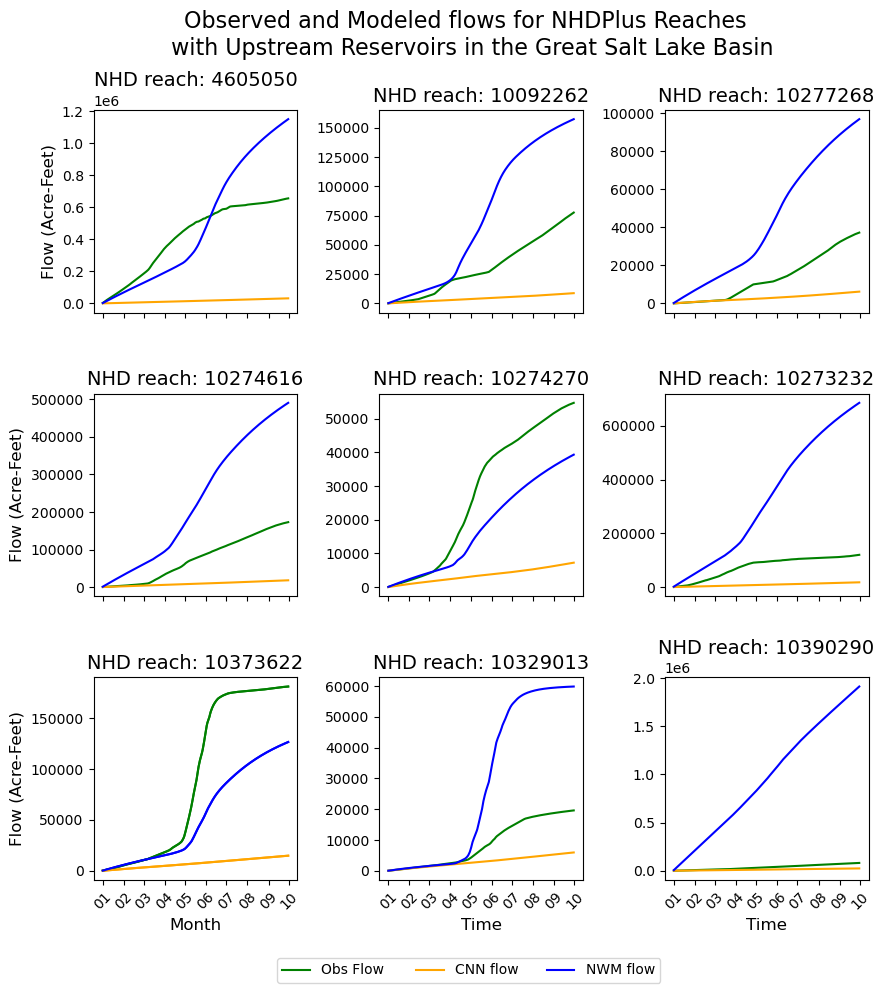

In [29]:
model = 'CNN'
plotname = 'CNN_TS_plot'
freq = 'D'
supply = True
title = 'Observed and Modeled flows for NHDPlus Reaches \n with Upstream Reservoirs in the Great Salt Lake Basin'
FigureGenerator.TS_plot(SitesDict, model, plotname, title, freq, supply)

In [31]:
import importlib
importlib.reload(FigureGenerator)

<module 'FigureGenerator' from '/home/ec2-user/SageMaker/01.projects/01.ciroh_p8/NWM-ML/savalan/FigureGenerator.py'>

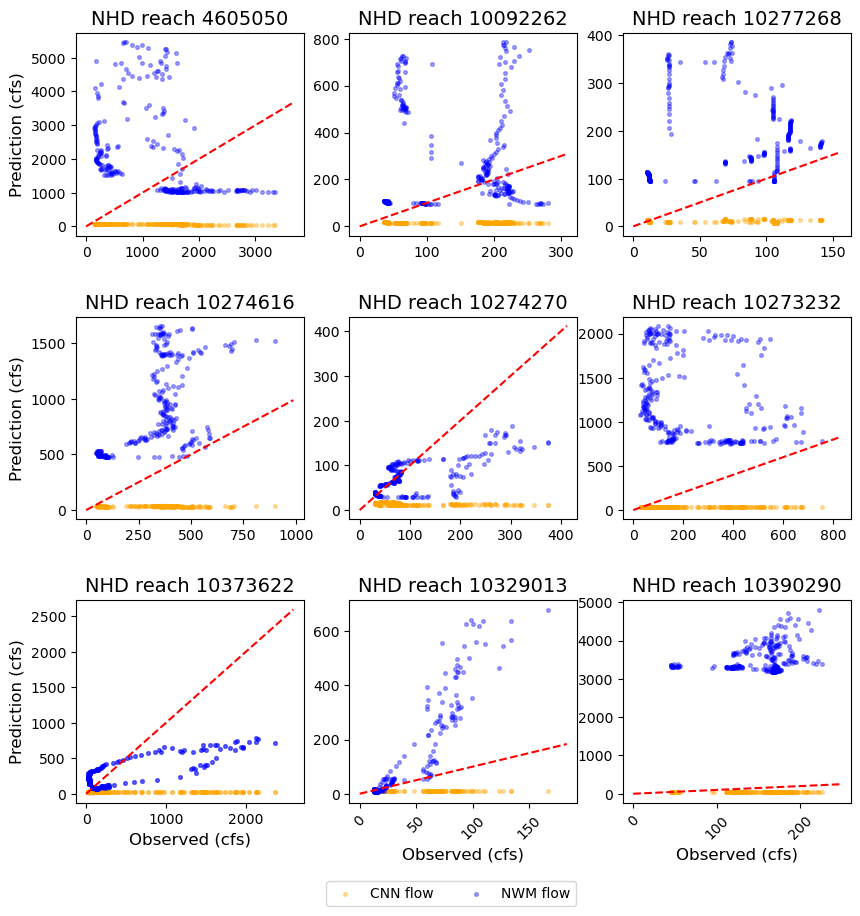

In [32]:
plotname = 'CNN_ParityPlot'
FigureGenerator.Parity_plot(SitesDict, model, plotname)

In [38]:
import AWS_transfer
model = 'CNN'
AWS_transfer.Predictions2AWS(model)

Pushing files to AWS


100% |########################################################################|
